# Certainty Based Prediction Analysis

- So far our models are not powerful enough to be useful.
- So we should consider two metrics.
- Single prediction entropy and play-average entropy.
- The intuition between play-average entropy is that we have more certainty about the play as a whole instead of just that one prediction.

We can see in both instances that low entropy predictions, both by play AND by individual predictions are more accurate.

This approach offers slightly higher coverage and better top 3 accuracy than simple probability cutoff.

In [1]:
import random
random.seed(42)  # Replace 42 with your desired seed value

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from nfl_data_bowl.data_utils.data_common import load_and_filter_data, filter_passing_plays_only, process_game_scores
from nfl_data_bowl.data_utils.data_historical import (
    HistoricalMultiRoutePlayDataset,
    create_game_play_pairs,
    create_batch_data,
    process_game_scores,
    DataMappings,
    create_week_stratified_split
)
from nfl_data_bowl.train import train_route_predictor, MultiRouteLoss
from torch_geometric.loader import DataLoader
import torch
from nfl_data_bowl.utils.evaluate import analyze_distributional_drift, classification_report, plot_rolling_performance, plot_metrics_across_datasets, evaluate_route_predictions_table
import numpy as np
import pandas as pd
from nfl_data_bowl.utils.evaluate import evaluate_route_predictions_table
import pickle
from nfl_data_bowl.models.gnn_historical_enhanced import PlayGNN
import xgboost as xgb
from nfl_data_bowl.data_utils.data_xgb import get_players_by_frame, join_receiver_analysis_to_df
from nfl_data_bowl.train_xgb import train_route_prediction_pipeline, prepare_route_prediction_data
from nfl_data_bowl.utils.detailed_evaluation import groupby_entropy_and_accuracy, plot_entropy_and_accuracy, accuracy_report_by_entropy, get_high_confidence_metrics, print_metrics_summary
import matplotlib.pyplot as plt

In [4]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

import warnings

tracking = load_and_filter_data(weeks=list(range(6,10)), base_path="..")
tracking_passing_only = filter_passing_plays_only(tracking)
tracking_passing_only = process_game_scores(tracking_passing_only)
tracking_passing_only = tracking_passing_only.sort_values(by=["time"])
print(tracking_passing_only.shape)

loaded
merged player play
merged plays
Dropped wasInitialPassRusher due to 100.00% missing values
Dropped timeToPressureAsPassRusher due to 100.00% missing values
Dropped getOffTimeAsPassRusher due to 100.00% missing values
Dropped wasRunningRoute due to 75.90% missing values
Dropped blockedPlayerNFLId1 due to 72.42% missing values
Dropped blockedPlayerNFLId2 due to 97.42% missing values
Dropped blockedPlayerNFLId3 due to 100.00% missing values
Dropped pressureAllowedAsBlocker due to 70.23% missing values
Dropped timeToPressureAllowedAsBlocker due to 97.65% missing values
Dropped pff_primaryDefensiveCoverageMatchupNflId due to 100.00% missing values
Dropped pff_secondaryDefensiveCoverageMatchupNflId due to 100.00% missing values
Dropped passLength due to 46.45% missing values
Dropped targetX due to 48.66% missing values
Dropped targetY due to 48.66% missing values
Dropped dropbackDistance due to 37.08% missing values
Dropped timeToThrow due to 46.54% missing values
Dropped timeInTackle

## Re-generate Datasets

In [5]:
tracking_passing_only.loc[
    (tracking_passing_only.routeRan.isna()) & (tracking_passing_only.position.isin(('WR', 'TE', 'RB'))), 
     'routeRan'
] = 'BLOCKING'

In [6]:
unique_routes = sorted([route for route in tracking_passing_only.routeRan.unique() if not pd.isna(route)])
print(len(unique_routes))
unique_routes

13


['ANGLE',
 'BLOCKING',
 'CORNER',
 'CROSS',
 'FLAT',
 'GO',
 'HITCH',
 'IN',
 'OUT',
 'POST',
 'SCREEN',
 'SLANT',
 'WHEEL']

In [7]:
with open("mapping.pkl", "rb") as f:
    mappings = pickle.load(f)

In [8]:
dataset = HistoricalMultiRoutePlayDataset(
    df=tracking_passing_only,
    game_play_pairs=create_game_play_pairs(tracking_passing_only),
    target_df=tracking_passing_only[['gameId','playId','routeRan']],
    offense_positions=['QB', 'RB', 'WR', 'TE'],
    defense_positions=['CB', 'SS', 'FS', 'LB', 'OLB', 'ILB'],
    eligible_positions=['WR', 'TE', 'RB'],
    n_frames=1,
    device='cpu',
    unique_routes=unique_routes,
    mappings=mappings,  # Pass the mappings object
    n_workers=8,
    teams_per_chunk=4,
    max_history_plays=6,
    augment=False,
    do_not_augment_weeks=[7, 8]
)

Precomputing graphs using team-based parallel processing


Processing team chunks: 100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.06s/it]


In [9]:
train_weeks = list(range(5,6))
val_weeks = list(range(6,8))
test_weeks = list(range(8,10))

In [10]:
train_loader, val_loader, test_loader, indices, week_ranges = create_week_stratified_split(
        dataset, 
        train_weeks=train_weeks,
        val_weeks=val_weeks,
        test_weeks=test_weeks,
        # train_weeks=list(range(1,3)),
        # val_weeks=list(range(3,4)),
        # test_weeks=list(range(3,4)),
        batch_size=128, 
        random_seed=42,
        preserve_time_order=False,
        val_random=False  # Whether to randomly sample validation set from train period
)

Train set size: 0
Validation set size: 2022
Test set size: 1960
Train weeks: [5]
Validation weeks: [6, 7]
Test weeks: [8, 9]


## GNN Predictions

In [11]:
model = PlayGNN(
    num_positions=20,
    hidden_dim=48,
    num_gnn_layers=3,
    num_route_classes=dataset.num_route_classes, # for -1 or NaN
    dropout=0.05,
    max_downs=4,
    max_quarters=5,
    num_teams=32,
)

In [12]:
PATH = "model_1_6.pt"
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()

PlayGNN(
  (position_embedding): Embedding(20, 4)
  (down_emb): Embedding(4, 2)
  (quarter_emb): Embedding(5, 2)
  (team_emb): Embedding(32, 8)
  (player_emb): Embedding(1000, 16)
  (gnn_layers): ModuleList(
    (0): GATv2Conv(41, 48, heads=2)
    (1-2): 2 x EnhancedGATBlock(
      (gat): GATv2Conv(48, 48, heads=2)
      (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.05, inplace=False)
    )
  )
  (frame_lstm): LSTM(48, 48, num_layers=2, batch_first=True, dropout=0.05, bidirectional=True)
  (historical_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=240, out_features=96, bias=True)
    (1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.05, inplace=False)
    (4): Linear(in_features=96, out_features=48, bias=True)
    (5): LayerNorm((48,), eps=1e-05, elemen

In [13]:
metrics_gnn, (y_test, y_pred, y_pred_proba, predictions_df) = evaluate_route_predictions_table(
    model, val_loader, dataset, "cpu", softmax=True
)
metrics_gnn['display_tables']()


=== Per-Class Performance ===


,Route,Actual Count,Predicted Count,Precision,Recall,F1-score,Support
0,ANGLE,344,413,0.218,0.262,0.238,344.000000
1,BLOCKING,1047,1177,0.243,0.273,0.257,1047.000000
2,SCREEN,377,155,0.187,0.077,0.109,377.000000
3,SLANT,526,237,0.139,0.063,0.087,526.000000
4,WHEEL,38,5,0.000,0.000,0.000,38.000000
5,CORNER,370,167,0.120,0.054,0.074,370.000000
6,CROSS,839,1214,0.236,0.342,0.280,839.000000
7,FLAT,1251,1653,0.353,0.466,0.402,1251.000000
8,GO,1678,2471,0.304,0.448,0.362,1678.000000
9,HITCH,1314,1041,0.217,0.172,0.192,1314.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.253,0.440,0.586



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.702,1.743,0.460,0.171,-2.156,-1.909



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.188,0.188,0.180,9933.000
1,weighted avg,0.228,0.253,0.233,9933.000


## XGB Predictions

In [14]:
import tqdm

# Example usage
game_id = 2022091105
play_id = 140

games = list(tracking_passing_only.gameId.unique())

enriched_df = None
tracking_subset = tracking_passing_only.copy()
tracking_subset["distance_from_los"] = np.abs(tracking_subset["x"] - tracking_subset["absoluteYardlineNumber"])
tracking_subset["distance_from_sideline"] = np.minimum(tracking_subset["y"], 53.3 - tracking_subset["y"])
pairs = set()
for item in list(tracking_subset[['gameId', 'playId']].to_numpy()):
    pairs.add((item[0].item(), item[1].item()))
i = 0
for game_id, play_id in list(pairs):
    i += 1
    if i % 500 == 0:
        print(i)
        print(enriched_df.shape)
    # Option 2: Use pre-computed frame data
    frame_data = get_players_by_frame(tracking_subset[(tracking_subset.gameId == game_id) & (tracking_subset.playId == play_id)])
    if enriched_df is None:
        enriched_df = join_receiver_analysis_to_df(tracking_subset, game_id, play_id, True, frame_data)
    else:
        try:
            tmp = join_receiver_analysis_to_df(tracking_subset, game_id, play_id, True, frame_data)
        except Exception as e:
            print(e)
            print(f'game, play: {game_id}, {play_id}')
        enriched_df = pd.concat([enriched_df, tmp])

500
(5489, 121)
1000
(10990, 121)
1500
(16490, 121)
2000
(21990, 121)
2500
(27490, 121)
3000
(32990, 121)
3500
(38490, 121)


In [15]:
with open("xgb_model.pkl", "rb") as f:
    xgb_model = pickle.load(f)

with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("encoders.pkl", "rb") as f:
    encoders = pickle.load(f)

In [16]:
metrics_xgb, (y_test, y_pred, y_pred_proba, predictions_df) = evaluate_route_predictions_table(
    xgb_model, 
    val_loader, 
    dataset, "cpu", 
    softmax=True,
    plays_df=enriched_df,
    feature_encoders=encoders, 
    scaler=scaler
)
metrics_xgb['display_tables']()

Trying XGB

=== Per-Class Performance ===


,Route,Actual Count,Predicted Count,Precision,Recall,F1-score,Support
0,ANGLE,344,36,0.472,0.049,0.089,344.000000
1,BLOCKING,1047,965,0.402,0.371,0.386,1047.000000
2,SCREEN,377,65,0.662,0.114,0.195,377.000000
3,SLANT,526,49,0.469,0.044,0.080,526.000000
4,WHEEL,38,6,0.833,0.132,0.227,38.000000
5,CORNER,370,81,0.296,0.065,0.106,370.000000
6,CROSS,839,973,0.319,0.369,0.342,839.000000
7,FLAT,1251,2113,0.425,0.717,0.533,1251.000000
8,GO,1678,3311,0.336,0.662,0.445,1678.000000
9,HITCH,1314,1750,0.239,0.318,0.273,1314.000000



=== Top-K Accuracy ===


,Metric,Top-1 (standard),Top-2,Top-3
0,Accuracy Type,0.344,0.541,0.682



=== Uncertainty Metrics ===


,Mean Entropy,Median Entropy,Mean Normalized Entropy,Mean Entropy Margin,Mean Log Likelihood,Median Log Likelihood
0,1.898,2.044,0.513,0.120,-1.814,-1.758



=== Overall Metrics ===


,Average Type,precision,recall,f1-score,support
0,macro avg,0.421,0.237,0.234,9933.000
1,weighted avg,0.364,0.344,0.295,9933.000


# Analyze and Filter By Entropy

- So far our models are not powerful enough to be useful.
- So we should consider two metrics.
- Single prediction entropy and play-average entropy.

We can see in both instances that low entropy predictions, both by play AND by individual predictions are more accurate.

## GNN

2022
9933


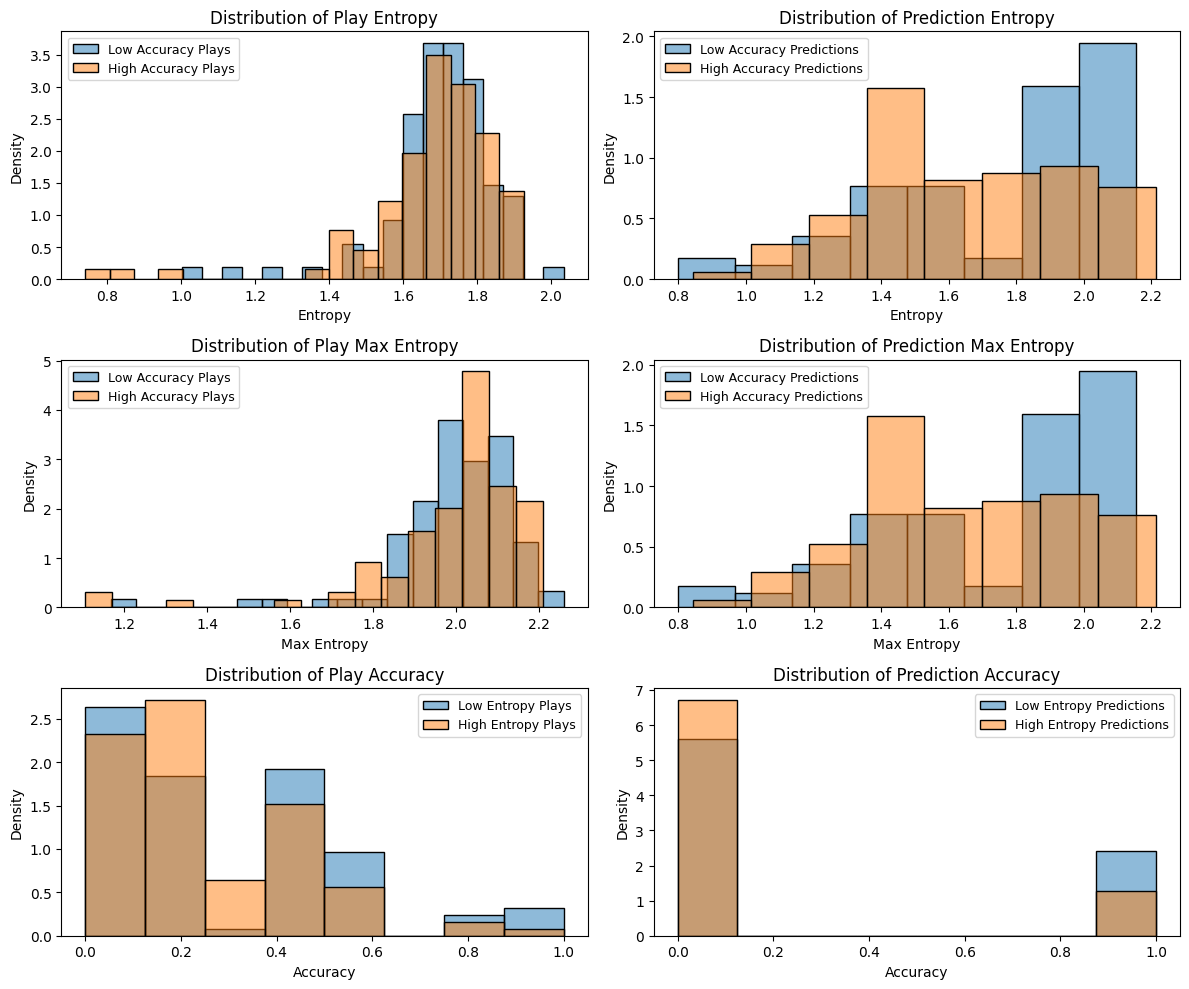

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Now axs is a 2D array and you can either:
# Method 1: Access using grid coordinates
ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[2, 0]
ax4 = axs[0, 1]
ax5 = axs[1, 1]
ax6 = axs[2, 1]

gnn_output_by_play = groupby_entropy_and_accuracy(metrics_gnn["predictions_df"], k=100)
plot_entropy_and_accuracy(
    **gnn_output_by_play,
    ax1=ax1, ax2=ax2, ax3=ax3,
    title_update='Play',
    plot_type='hist'
    
)

gnn_output_by_pred = groupby_entropy_and_accuracy(metrics_gnn["predictions_df"], k=100, extra_groupings=['player_id'])
plot_entropy_and_accuracy(
    **gnn_output_by_pred,
    ax1=ax4,
    ax2=ax5,
    ax3=ax6,
    title_update='Prediction',
    plot_type='hist'
)
plt.tight_layout()
plt.show()

In [39]:
accuracy_report_by_entropy(metrics_gnn["predictions_df"], gnn_output_by_play, cutoff=2.1)

Initial DF size: 9933
Final filtering size: 657

=== Filtered by Row Entropy Only - Coverage: N = 9291/9933 93.54 % ===
              precision    recall  f1-score   support

           0       0.22      0.26      0.24       343
           1       0.25      0.28      0.26       998
           2       0.12      0.06      0.08       335
           3       0.25      0.35      0.29       761
           4       0.36      0.48      0.41      1197
           5       0.31      0.46      0.37      1588
           6       0.22      0.16      0.19      1206
           7       0.12      0.06      0.08       651
           8       0.17      0.11      0.13       815
           9       0.15      0.11      0.13       501
          10       0.19      0.08      0.11       362
          11       0.15      0.07      0.09       498
          12       0.00      0.00      0.00        36

    accuracy                           0.26      9291
   macro avg       0.19      0.19      0.18      9291
weighted avg  

In [31]:
# Get metrics for high confidence predictions
metrics = get_high_confidence_metrics(
    metrics_gnn["predictions_df"],
    unique_routes=unique_routes,
    confidence_threshold=0.5,
    k=3
)
print_metrics_summary(metrics, 3)

top1_accuracy: 0.33
top2_accuracy: 0.53
top3_accuracy: 0.65

High Confidence Predictions (threshold >= 50.0%)
Coverage: 16.8% (1,671 / 9,933 predictions)

Top-3 Accuracy: 64.5%

Classification Report:
Class            Precision     Recall         F1    Support
-------------------------------------------------------
ANGLE                0.182      0.027      0.048       73.0
BLOCKING             0.266      0.483      0.343      261.0
CORNER               0.222      0.051      0.083       39.0
CROSS                0.397      0.458      0.425      155.0
FLAT                 0.415      0.671      0.512      340.0
GO                   0.328      0.456      0.381      226.0
HITCH                0.231      0.018      0.034      165.0
IN                   0.286      0.025      0.045       81.0
OUT                  0.056      0.010      0.017      103.0
POST                 0.000      0.000      0.000       47.0
SCREEN               0.288      0.190      0.229      100.0
SLANT                0.

## XGB

2022
9933


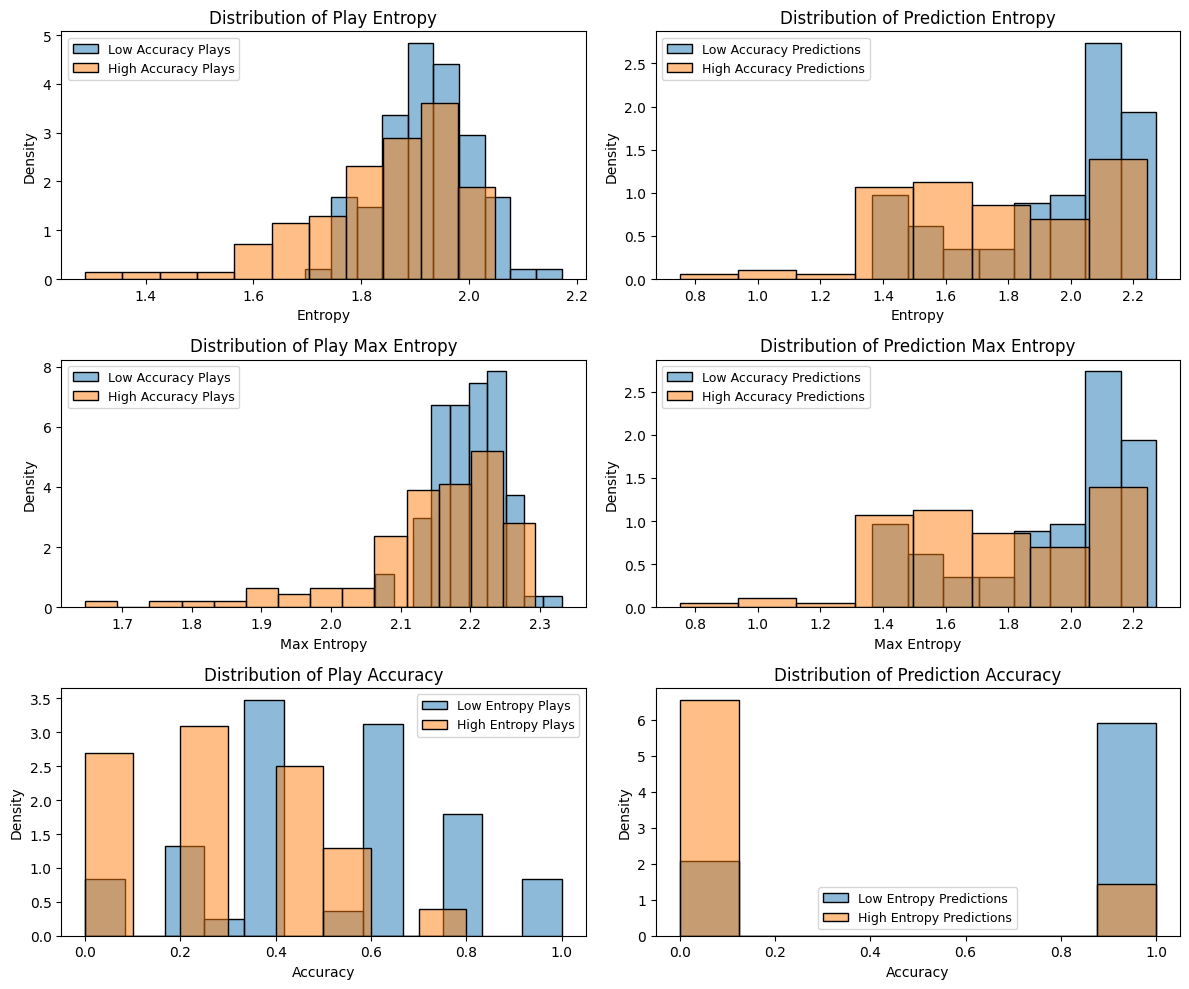

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Now axs is a 2D array and you can either:
# Method 1: Access using grid coordinates
ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[2, 0]
ax4 = axs[0, 1]
ax5 = axs[1, 1]
ax6 = axs[2, 1]

xgb_output_by_play = groupby_entropy_and_accuracy(metrics_xgb["predictions_df"], k=100)
plot_entropy_and_accuracy(
    **xgb_output_by_play,
    ax1=ax1, ax2=ax2, ax3=ax3,
    title_update='Play',
    plot_type='hist'
)

xgb_output_by_pred = groupby_entropy_and_accuracy(metrics_xgb["predictions_df"], k=100, extra_groupings=['player_id'])
plot_entropy_and_accuracy(
    **xgb_output_by_pred,
    ax1=ax4,
    ax2=ax5,
    ax3=ax6,
    title_update='Prediction',
    plot_type='hist'
)
plt.tight_layout()
plt.show()

In [33]:
accuracy_report_by_entropy(metrics_xgb["predictions_df"], xgb_output_by_play, cutoff=2)

Initial DF size: 9933
Final filtering size: 362

=== Filtered by Row Entropy Only - Coverage: N = 4630/9933 46.61 % ===
              precision    recall  f1-score   support

           0       0.47      0.05      0.09       342
           1       0.50      0.40      0.44       732
           2       0.25      0.02      0.04        53
           3       0.52      0.54      0.53       205
           4       0.45      0.88      0.59       928
           5       0.41      0.89      0.56       806
           6       0.43      0.10      0.16       441
           7       0.64      0.03      0.06       225
           8       0.38      0.02      0.04       226
           9       0.50      0.02      0.05       125
          10       0.71      0.15      0.24       245
          11       0.53      0.07      0.12       264
          12       0.83      0.13      0.23        38

    accuracy                           0.45      4630
   macro avg       0.51      0.25      0.24      4630
weighted avg  

## Top Metrics

In [35]:
# Get metrics for high confidence predictions
metrics = get_high_confidence_metrics(
    metrics_xgb["predictions_df"],
    unique_routes=unique_routes,
    confidence_threshold=0.55,
    k=3
)

print(metrics.keys())

# Print formatted summary
print_metrics_summary(metrics, 3)

top1_accuracy: 0.71
top2_accuracy: 0.81
top3_accuracy: 0.86
dict_keys(['classification_report', 'top3_accuracy', 'coverage', 'n_predictions', 'n_total', 'confidence_threshold', 'debug_info'])

High Confidence Predictions (threshold >= 55.0%)
Coverage: 2.8% (282 / 9,933 predictions)

Top-3 Accuracy: 85.8%

Classification Report:
Class            Precision     Recall         F1    Support
-------------------------------------------------------
ANGLE                0.400      0.182      0.250       11.0
BLOCKING             0.675      0.852      0.754       61.0
CORNER               0.000      0.000      0.000        6.0
CROSS                0.680      0.723      0.701       47.0
FLAT                 0.674      0.879      0.763       66.0
GO                   0.833      0.778      0.805       45.0
HITCH                0.000      0.000      0.000        6.0
IN                   0.000      0.000      0.000        3.0
OUT                  0.000      0.000      0.000        4.0
POST          